In [52]:
import numpy as np
import pandas as pd
from random import sample

In [53]:
def move_agents(old_SuSca, old_agents, N):
    """
    Function to move the agents on the sugarscape using a pandas DataFrame.
    Implements one round where all agents move once, ensuring no two agents occupy the same cell.
    
    Parameters
    ==========
    SuSca : 2D numpy array representing the sugarscape (sugar levels at each position).
    agents : pandas DataFrame containing agent attributes and positions.
    N : Size of the sugarscape grid (NxN).
    max_vision : Maximum vision range for agents.

    Returns
    =======
    Updated sugarscape grid and agents DataFrame.
    """
    Nx, Ny = old_SuSca.shape
    SuSca = old_SuSca.copy()
    
    # Shuffle agent order to randomize movement
    agents = old_agents.sample(frac=1).reset_index(drop=True)
    
    # Create a set of occupied cells (x, y)
    occupied_cells = set(zip(agents["x"], agents["y"]))

    # remove_list = []
    
    for i, agent in agents.iterrows():
        # Get agent's properties
        x, y = int(agent["x"]), int(agent["y"])   # position of the agent 
        vision = int(agent["vision"])  # Scale vision to an integer
        sugar = agent["sugar"]
        metabolism = agent["metabolism"]
        lifespan = agent['lifespan']
        
        # Determine visible cells within vision range
        visible_positions = []
        for dx in range(-vision, vision + 1):
            for dy in range(-vision, vision + 1):
                if abs(dx) + abs(dy) <= vision:  # Manhattan distance
                    new_x = int((x + dx) % Nx)
                    new_y = int((y + dy) % Ny)
                    if (new_x, new_y) not in occupied_cells:  # Skip occupied cells
                        visible_positions.append((new_x, new_y))
        
        if not visible_positions:
            # No valid moves; this agent is stuck
            continue
        
        # Find the cell with the highest sugar within vision
        # Here it might be possible to add a new lambda key, representing radiation for example. 
        best_cell = max(
            visible_positions,
            key=lambda pos: SuSca[pos[0], pos[1]]
        )
        
        # Move agent to the best cell
        new_x, new_y = best_cell
        agents.at[i, "x"] = new_x
        agents.at[i, "y"] = new_y
        
        # Update occupied cells safely
        if (x, y) in occupied_cells:
            occupied_cells.remove((x, y))  # Free the old cell
        occupied_cells.add((new_x, new_y))  # Mark the new cell as occupied
        
        
        # Collect sugar from the new cell
        if agents.at[i, "sugar"] < agents.at[i, "carrying capacity"]:
            # How much sugar that is in the cell
            available_sugar = SuSca[new_x, new_y]
            
            # Sugar the agent can take based on caring capacity
            sugar_to_take = min(available_sugar, agents.at[i, "carrying capacity"] - agents.at[i, "sugar"])
          
            agents.at[i, "sugar"] += sugar_to_take
            SuSca[new_x, new_y] -= sugar_to_take # Remove sugar from cell
        
        # Pay the metabolic cost
        agents.at[i, "sugar"] -= metabolism

    # Remove agents with sugar <= 0 (they "die"), then reset the index of the DataFrame
    agents = agents[agents["sugar"] > 0].reset_index(drop=True)
    
    return SuSca, agents


Initialize the sugarscape in the "classical" way.

In [54]:
def initialize_sugarscape_gaussian(N, spot_positions, spot_widths, max_sugar):
    """
    Function to generate a sugarscape with Gaussian-distributed sugar levels.
    
    Parameters
    ==========
    N : int
        Size of the sugarscape lattice (NxN).
    spot_positions : array-like
        List of (x, y) positions where sugar "hotspots" are centered.
    spot_widths : array-like
        List of standard deviations (sigma) for the Gaussian spread of each hotspot.
    max_sugar : float
        Maximum sugar value to normalize the distribution.
        
    Returns
    =======
    SuSca : ndarray
        2D array of sugar levels.
    """
    # Initialize the sugarscape grid
    SuSca = np.zeros((N, N), dtype=float)

    # Create a grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))

    # Define the Gaussian function
    def gauss(r, sigma):
        return np.exp(-r**2 / (2 * sigma**2))

    # # defining threshold for low sugar cell
    # threshold = 0.1 * max_sugar
    


    # Loop over all sugar hotspots
    for i, (x_center, y_center) in enumerate(spot_positions):
        dx = (X - x_center).astype(np.float64)
        dy = (Y - y_center).astype(np.float64)
        
        # Apply periodic boundary conditions
        dx -= np.round(dx / N) * N
        dy -= np.round(dy / N) * N

        # Compute the radial distance
        r = np.sqrt(dx**2 + dy**2)

        # Add Gaussian sugar levels to the grid
        SuSca += gauss(r, spot_widths[i])

    # Normalize sugar levels to range [0, 10]
    SuSca -= np.min(SuSca)  # Ensure the minimum is 0
    SuSca /= np.max(SuSca)  # Normalize to [0, 1]
    SuSca *= max_sugar      # Scale to [0, max_sugar]
    
    return SuSca



In [55]:
def regenerate_hotspots(SuSca, N, num_hotspots, max_sugar, peak_value=5.0, sigma=3.0):
    """
    Function to regrow sugar in the Sugarscape using gradient-based hotspots.

    Parameters
    ==========
    SuSca : ndarray
        Current sugar levels in the Sugarscape.
    N : int
        Size of the Sugarscape (NxN).
    num_hotspots : int
        Number of new sugar hotspots to create.
    max_sugar : float
        Maximum possible sugar value per cell.
    peak_value : float
        Maximum sugar value at the hotspot center.
    sigma : float
        Standard deviation controlling the spread of the sugar gradient.

    Returns
    =======
    SuSca : ndarray
        Updated sugar levels with new hotspots.
    """
    # Create a grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))

    # Define the Gaussian function
    def gauss(r, sigma):
        return np.exp(-r**2 / (2 * sigma**2))

    # Add new sugar gradients to the Sugarscape
    for _ in range(num_hotspots):
        # Randomly select a new hotspot center
        x_center, y_center = np.random.randint(0, N, size=2)

        # Calculate distances with periodic boundary conditions
        dx = (X - x_center).astype(np.float64)
        dy = (Y - y_center).astype(np.float64)
        dx -= np.round(dx / N) * N
        dy -= np.round(dy / N) * N
        r = np.sqrt(dx**2 + dy**2)

        # Add a new sugar gradient to the Sugarscape
        new_sugar = peak_value * gauss(r, sigma)
        SuSca += new_sugar

    # Clip sugar levels to ensure they don't exceed max_sugar
    SuSca = np.clip(SuSca, 0, max_sugar)
    
    
    return SuSca


Defining GA-Logic. All pretty self explanatory. 


In [ ]:
def calculate_fitness(agent): 
    # A simple fitness function
    # What do we want to have as fitness? 
    fitness =agent['sugar'] #* 1/agent['metabolism'] * agent['vision'] * agent['carrying capacity']
    return fitness

def select_parents(agents, num_parents):
    parents = []
    for _ in range(num_parents):
        selected = agents.sample(3)  # Select 3 random agents for the tournament
        parent = selected.loc[selected['fitness'].idxmax()]  # Select the best one
        parents.append(parent)
    return pd.DataFrame(parents)

def crossover(parent1, parent2, max_min_values):
    crossover_point = np.random.randint(0, 4)  # Randomly choose a point (since there are 3 traits)
    
    child1 = parent1.copy()
    child2 = parent2.copy()

    # Swap the genes after the crossover point
    for gene in range(crossover_point):
        gene_name = gene+2 # +2 because we dont want to choose the first colums in df (origin,sugar)
        child1.iloc[gene_name], child2.iloc[gene_name] = parent2.iloc[gene_name], parent1.iloc[gene_name]
    

    init_sugar = np.random.randint(max_min_values['sugar'][0], max_min_values['sugar'][1])
    # Set the initial age to 0 and sugar to 0
    child1['age'], child2['age'] = 0, 0 
    child1['sugar'], child2['sugar'] = init_sugar, init_sugar
    return child1, child2

# def mutate(agent, max_min_values, mutation_rate=0.01):
#     pollution_rate = agent['pollution rate']
#     mutation_rate += pollution_rate 
#     if np.random.rand() < mutation_rate:
#         # Randomly choose one attribute to mutate
#         attribute_to_mutate = np.random.choice(['metabolism', 'vision','carrying capacity', 'lifespan'])
#         values = max_min_values[attribute_to_mutate]
#         agent[attribute_to_mutate] = np.random.randint(values[0], values[1])
#     return agent

def mutate(agent, max_min_values, mutation_rate=0.01):
    pollution_rate = agent['pollution rate']
    attribute_arr = ['metabolism', 'vision','carrying capacity', 'lifespan']
    if np.random.rand() < mutation_rate:

        # Randomly choose one attribute to mutate
        attribute_to_mutate = np.random.choice(attribute_arr)
        values = max_min_values[attribute_to_mutate]
        agent[attribute_to_mutate] = np.random.randint(values[0], values[1])

    if pollution_rate > 0:
        if np.random.rand() < pollution_rate:
            attr_mult = [1, -1, -1, -1]
            for i, attribute in enumerate(attribute_arr):
                values = max_min_values[attribute]
                agent[attribute] = attr_mult[i] * int(round(np.random.randint(values[0], values[1])/2))

    return agent


def replace_population(agents, new_agents):
    return pd.concat([agents, new_agents]).reset_index(drop=True)

In [57]:
int(round(3.5))

4

Function to convert a 2 dimensional numpy array into a RGB image.

In [58]:
def convert2RBG(SuSca, RGB0, RGB1):
    """
    Function to convert the 2 dimensional numpy array into a RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the prisoner's dilemma.
    RGB0 : Components R, G, B of the chosen color shade for minimum I_profile.
    RGB1 : Components R, G, B of the chosen color shade for maximum I_profile.
    """
    
    game_outcome = SuSca.copy()

    [n_rows, n_cols] = game_outcome.shape
    
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Set I_profile between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= 10
    
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB


In [59]:
import time
def update_canvas(SuSca, agents, canvas, N, window_size, step, tk):
    r0 = 0.25
    # Define the RGB colors for white and orange
    RGB1 = [0.1, 1.0, 0.1]  # Green for high values.
    RGB0 = [1.0, 1.0, 1.0]  # White for low values.

    canvas.delete('all')
    SU_cells = []

    color_image = convert2RBG(SuSca, RGB0, RGB1)

    # Use the converted RGB image to draw the cells
    for i in range(N):
        for j in range(N):
            # Get the color from the RGB image
            cell_color = color_image[i, j]
            hex_color = f'#{int(cell_color[0]*255):02x}{int(cell_color[1]*255):02x}{int(cell_color[2]*255):02x}'
            
            SU_cells.append(
                canvas.create_rectangle(
                    i / N * window_size, 
                    j / N * window_size,
                    (i + 1) / N * window_size,
                    (j + 1) / N * window_size, 
                    outline='', 
                    fill=hex_color,
                )
            )

    # Update the agents
    Agents_circ = []
    for _, agent in agents.iterrows():  # Iterating through each row in the DataFrame
        x = agent["x"]  # X-coordinate of the agent
        y = agent["y"]  # Y-coordinate of the agent

        if agent["pollution rate"]:
            color = "red"
        else:
            color = "black"
        # Drawing the agent as a circle
        Agents_circ.append(
            canvas.create_oval(
                (x + 0.5 - r0) / N * window_size,  # Top-left x-coordinate
                (y + 0.5 - r0) / N * window_size,  # Top-left y-coordinate
                (x + 0.5 + r0) / N * window_size,  # Bottom-right x-coordinate
                (y + 0.5 + r0) / N * window_size,  # Bottom-right y-coordinate
                outline='', 
                fill=color,
            )
        )

    tk.title(f'Iteration {step}')
    tk.update_idletasks()
    tk.update()
    time.sleep(.1)  # Increase to slow down the simulation.

Initialize the sugarscape


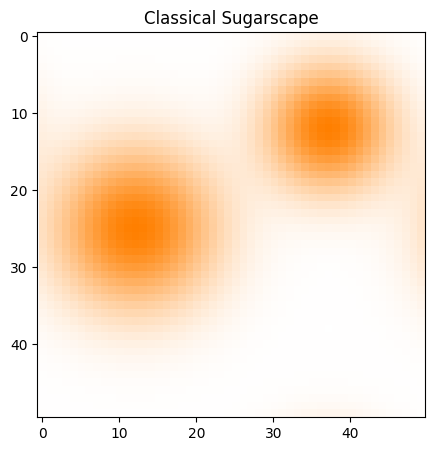

In [60]:
from matplotlib import pyplot as plt

N = 50  # Side of the sugarscape.
spot_positions = [(N //4, N // 2), (3 * N // 4, 1 * N // 4), ]  # Center of the sugar spots.
spot_widths = [N / 7, N / 9]  # Width of the sugar spots.
max_sugar = 10  # Maximum sugar level.


SuSca = initialize_sugarscape_gaussian(N, spot_positions, spot_widths, max_sugar)
# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# Plot the Sugarscape.
plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)  # Plot Sugarscape profile.
# Plot the reference points.
plt.title('Classical Sugarscape')
plt.axis('equal')
plt.show()       


In [61]:
mutated = np.concatenate((np.random.rand(100),np.zeros(300)))
print(mutated)

[0.05556636 0.78862864 0.56705802 0.50290056 0.91952274 0.526705
 0.2128175  0.78561211 0.70314232 0.81652843 0.19243296 0.64863371
 0.50947719 0.5462356  0.60454658 0.61551463 0.25630301 0.2873499
 0.07297394 0.52827422 0.0909804  0.45096404 0.07874442 0.3271361
 0.62224101 0.1896116  0.49291849 0.41719127 0.83299747 0.77567268
 0.55130566 0.10827464 0.84034169 0.55469589 0.28134676 0.89338231
 0.07297539 0.6195114  0.90759801 0.6767024  0.49945569 0.71666203
 0.46219315 0.84063916 0.12945295 0.53058714 0.57994625 0.26956794
 0.86622968 0.06290031 0.89064528 0.62828903 0.81852577 0.78994875
 0.44514706 0.32864159 0.45150482 0.42389578 0.43886179 0.79736591
 0.17997551 0.75601386 0.96618069 0.27040779 0.06090021 0.14349889
 0.58097419 0.26512226 0.32067479 0.13537823 0.10745149 0.98776941
 0.76975109 0.31850889 0.10828484 0.08665259 0.83686825 0.6402074
 0.6820374  0.76875421 0.23280014 0.81134223 0.84727943 0.03619997
 0.88229503 0.31228983 0.14940464 0.81906076 0.42409328 0.55105657


In [62]:
from random import sample

N = 50  # Size of the sugarscape with the agents.
A = 400  # Number of agents on the sugarscape.

x_positions = np.random.randint(0, N, A)  # Random X positions
y_positions = np.random.randint(0, N, A)  # Random Y positions
mutated = np.concatenate((np.random.rand(100),np.zeros(300)))

max_min_values = {
    'sugar': [1,25],
    'metabolism': [1,6],
    'carrying capacity': [10,20],
    'vision':[1,6],
    'lifespan': [20,50],
}

# Create the agents with random integers between 1 and 5
agents = pd.DataFrame({
    'origin': np.arange(0,A),
    'sugar': np.random.randint(max_min_values['sugar'][0], max_min_values['sugar'][1], A),               # Random integers between 1 and 5 for sugar
    'metabolism': np.random.randint(max_min_values['metabolism'][0], max_min_values['metabolism'][1], A),           # Random integers between 1 and 5 for metabolism
    'carrying capacity': np.random.randint(max_min_values['carrying capacity'][0], max_min_values['carrying capacity'][1], A),  # Carrying capacity
    'vision': np.random.randint(max_min_values['vision'][0], max_min_values['vision'][1], A),               # Random integers between 1 and 5 for vision
    'lifespan': np.random.randint(max_min_values['lifespan'][0], max_min_values['lifespan'][1], A),           # Initialize lifespan randomly
    'pollution rate': mutated,                      # Initialize age to 0
    'age' : np.zeros(A),                                # Initialize age to 0
    'fitness': np.zeros(A),                             # Initialize fitness to 0
    'x': x_positions,                                   # X-coordinate of agent
    'y': y_positions                                    # Y-coordinate of agent
})

In [63]:
import time
from tkinter import Tk
from tkinter import Canvas
import numpy as np


apply_GA = 20 # Apply GA logic after number of steps
N_skip = 1
MAX_STEP = 150
step = 0

# Visualize status every N_skip steps. 
window_size = 600



# Lists to store data from every step
iterations = []
num_agents = []
avg_metabolism = []
avg_carry = []
avg_vision = []
avg_age = []
avg_sugar = []


tk = Tk()
tk.geometry(f'{window_size + 20}x{window_size + 20}')
tk.configure(background='#000000')

canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
canvas.place(x=10, y=10, height=window_size, width=window_size)


def stop_loop(event):
    global running
    running = False
tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
running = True  # Flag to control the loop.

while running:
    # Move agents
    SuSca, agents = move_agents(SuSca, agents, N)  # Move the agents on the sugarscape.

    # increase the age of the agents and remove the ones that have lived happily their lifespan.
    agents['age'] += 1
    agents = agents[agents['age'] < agents['lifespan']]  
    
    # calculate the agents new fitness
    agents['fitness'] = agents.apply(calculate_fitness, axis=1)

    # Update animation frame.
    if step % N_skip == 0:
        update_canvas(SuSca, agents, canvas, N, window_size, step, tk)


    # Save data for plots
    iterations.append(step)
    num_agents.append(len(agents.copy()))  # Antalet agenter (kan förändras under simuleringen)
    avg_metabolism.append(agents["metabolism"].mean())  # Medelvärde av metabolism
    avg_carry.append(agents["carrying capacity"].mean())  # Medelvärde av metabolism
    avg_vision.append(agents["vision"].mean())  # Medelvärde av vision
    avg_age.append(agents["age"].mean())
    avg_sugar.append(agents["sugar"].mean())    
    
    if len(agents) < 15:
        running = False
     
    # after some steps, apply the GA logic
    if step > apply_GA:
        parents = select_parents(agents, 10)
        new_agents = []
        for i in range(0, len(parents), 2):
            parent1 = parents.iloc[i]
            parent2 = parents.iloc[i + 1]
            child1, child2 = crossover(parent1, parent2, max_min_values)
            child1 = mutate(child1, max_min_values)
            child2 = mutate(child2, max_min_values)
            new_agents.append(child1)
            new_agents.append(child2)
        agents = replace_population(agents, pd.DataFrame(new_agents))  # Keeping the old agents and adding the new ones to the population --> Population size grows each round

    
    # Periodically regenerate sugar hotspots
    if step % 10 == 0:  # Regenerate every 20 steps
        SuSca = regenerate_hotspots(SuSca, N=50, num_hotspots=3, max_sugar=10, peak_value=5, sigma=4)


    if step == MAX_STEP:
        running = False 
    
    step += 1 


tk.update_idletasks()
tk.update()
tk.mainloop()  # Release animation handle (close window to finish).


C:\Users\sagal\AppData\Local\Temp\ipykernel_11448\2977777223.py:76: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.1709059280542005' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  agents.at[i, "sugar"] += sugar_to_take


In [64]:
agents.to_csv('agents.csv', index=False)

# Save results in a pandas dataframe
abilities_results = pd.DataFrame({
    'metabolism': avg_metabolism,
    'carrying capacity': avg_carry,
    'vision': avg_vision,
    'age': avg_age,
    'sugar': avg_sugar
}) 

abilities_results.to_csv('results_sugar.csv', index=False)


In [65]:
abilities_results = pd.read_csv('results_sugar.csv')


151
151
151


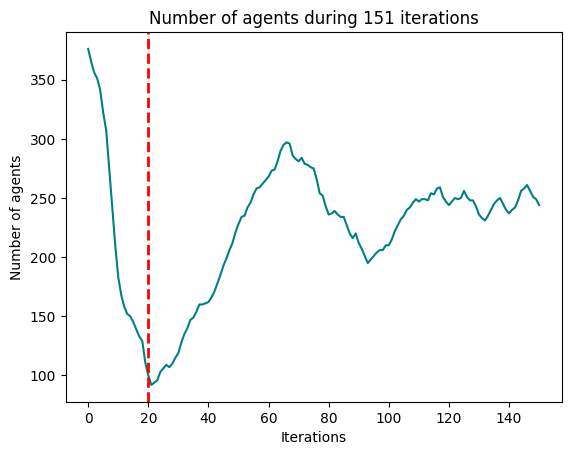

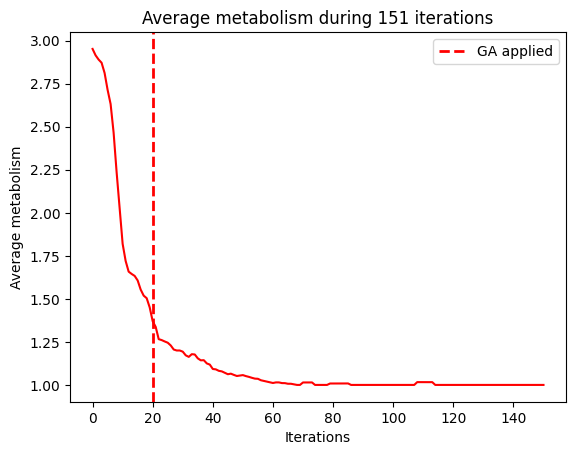

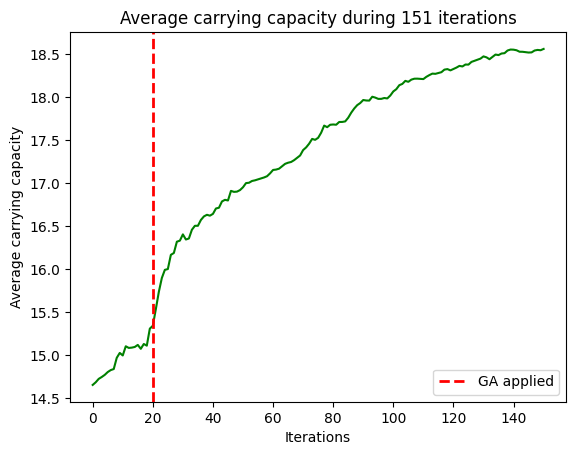

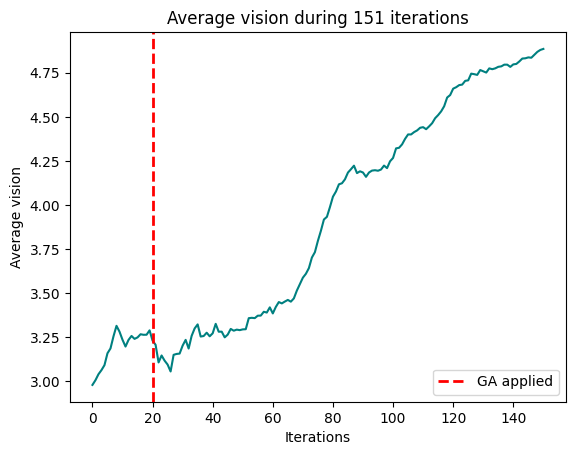

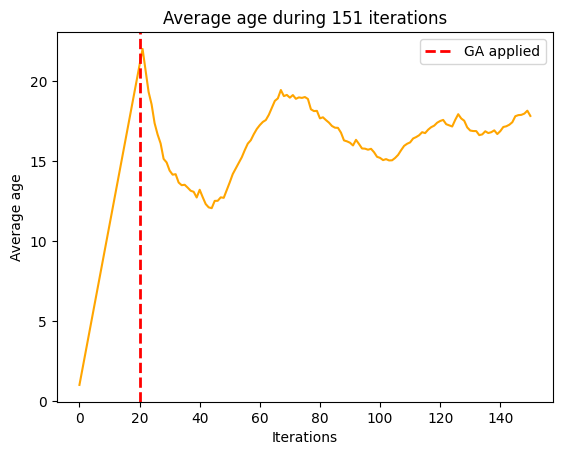

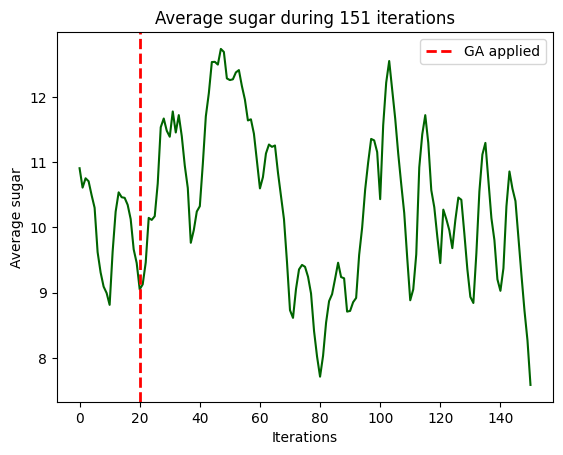

In [66]:
import matplotlib.pyplot as plt

colors = ['r', 'g','teal','orange','darkgreen']

print(len(abilities_results))
print(len(num_agents))
print(len(iterations))

plt.figure()
plt.plot(iterations, num_agents, color= 'teal')
plt.title(f'Number of agents during {len(iterations)} iterations')
plt.axvline(x=apply_GA, color='r', linestyle='--', linewidth=2, label="GA applied")
plt.xlabel('Iterations')
plt.ylabel('Number of agents')
plt.show()

plt.figure()
for ability in range(abilities_results.shape[1]):
    colomn_name = abilities_results.columns[ability]
    plt.plot(iterations,abilities_results[colomn_name], color= colors[ability])
    plt.title(f'Average {colomn_name} during {len(iterations)} iterations') 
    plt.xlabel('Iterations')
    plt.ylabel(f'Average {colomn_name}')
    plt.axvline(x=apply_GA, color='r', linestyle='--', linewidth=2, label="GA applied")
    plt.legend()
    plt.show()

In [67]:
abilities_results = pd.read_csv('results_all.csv')

151
151
151


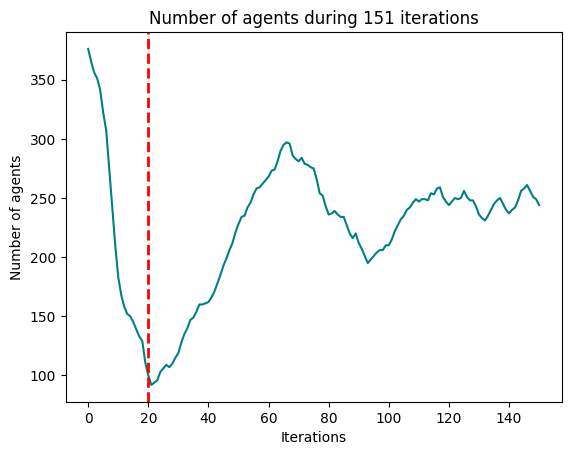

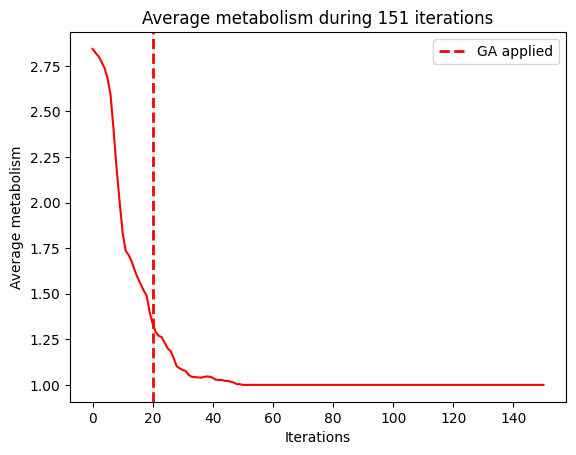

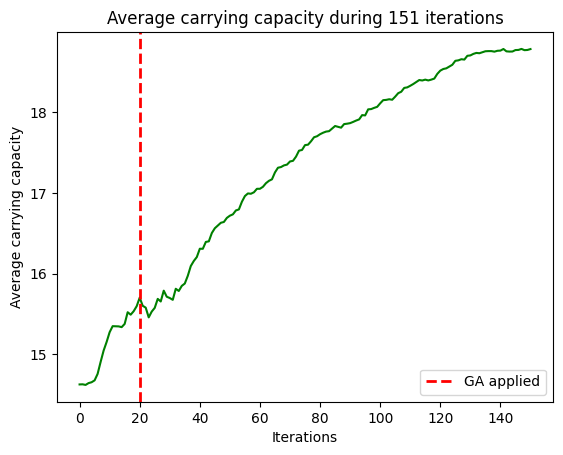

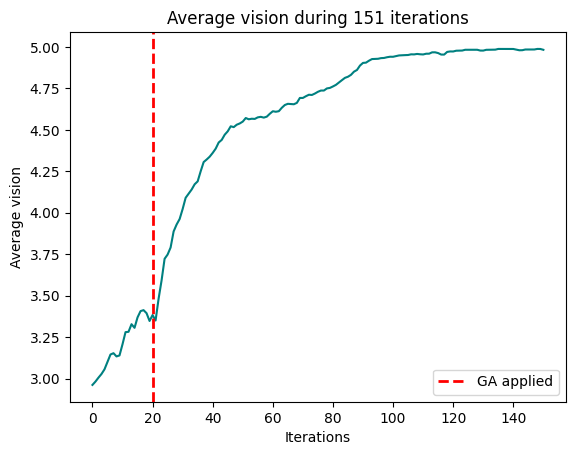

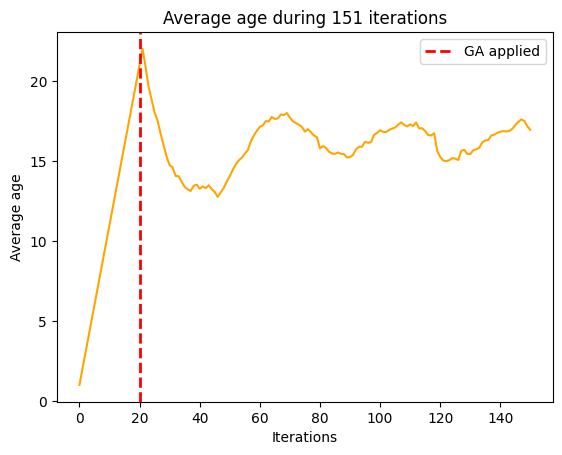

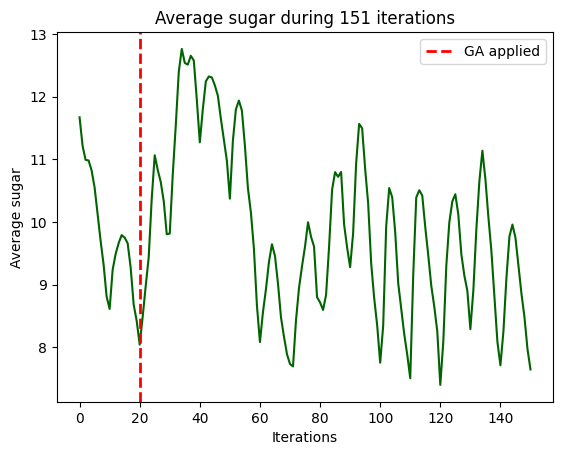

In [68]:
import matplotlib.pyplot as plt

colors = ['r', 'g','teal','orange','darkgreen']

print(len(abilities_results))
print(len(num_agents))
print(len(iterations))

plt.figure()
plt.plot(iterations, num_agents, color= 'teal')
plt.title(f'Number of agents during {len(iterations)} iterations')
plt.axvline(x=apply_GA, color='r', linestyle='--', linewidth=2, label="GA applied")
plt.xlabel('Iterations')
plt.ylabel('Number of agents')
plt.show()

plt.figure()
for ability in range(abilities_results.shape[1]):
    colomn_name = abilities_results.columns[ability]
    plt.plot(iterations,abilities_results[colomn_name], color= colors[ability])
    plt.title(f'Average {colomn_name} during {len(iterations)} iterations') 
    plt.xlabel('Iterations')
    plt.ylabel(f'Average {colomn_name}')
    plt.axvline(x=apply_GA, color='r', linestyle='--', linewidth=2, label="GA applied")
    plt.legend()
    plt.show()

Ändrade fitness (endast socker)
La till alla properties i crossover/mutation 
Fixade en max_min_values array, lättare att ha koll på ranges

Hur skall vi ha mutation? två funktioner eller samma?